因子1 Alpha191 alpha24

3.7816622257232666
Initialize dataview success.


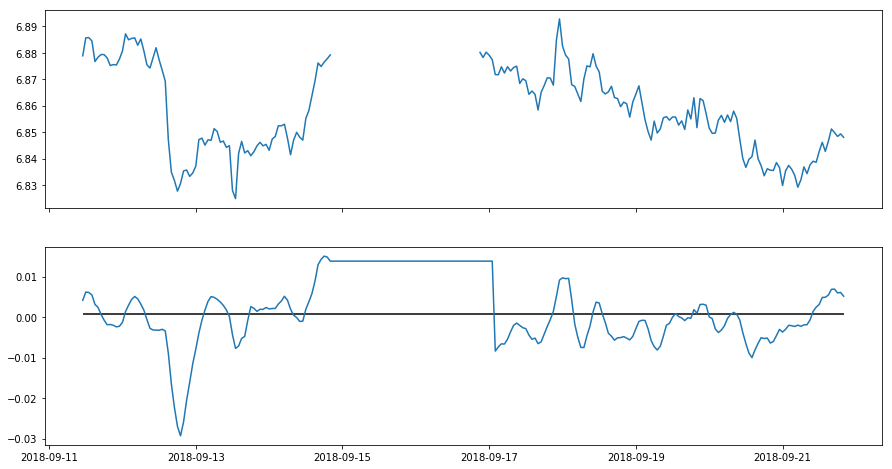

In [4]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/OANDA_M1'
props = {'fields': 'open,high,low,close,volume','symbol': 'USD_CNH:oanda', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
import matplotlib.pyplot as plt

def plot_chart(close,alpha,alpha_mean=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    ax1.hlines(alpha_mean, alpha.index[-250], alpha.index[-1])
    # plt.savefig('good')
    plt.show()
def RankPct(df):
    return df.rank(axis=1, pct=True)
alpha24 = dv.add_formula('alpha24','Sma(close-Delay(close,5),5,1)',add_data=True, register_funcs={'RankPct':RankPct})
import numpy as np
a=np.nan_to_num(alpha24.values)
alpha24_mean=np.mean(a)
alpha24_plot = dv.get_ts('alpha24', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, alpha24_plot,alpha24_mean)

In [5]:
np.mean(a)

0.00082097971660189967

In [6]:

# 进场信号
long = dv.add_formula('longAlpha24','If(Sma(close-Delay(close,5),5,1)>0.00082097971660189967 ,2,0)', add_data=True)
short = dv.add_formula("shortAlpha24","If(Sma(close-Delay(close,5),5,1)<=0.00082097971660189967 ,-2,0)", add_data=True)

# 出场信号
close_long = dv.add_formula("closeLongAlpha24","If(shortAlpha24==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortAlpha24","If(longAlpha24==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha024')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdAlpha1, dv,'longAlpha24','shortAlpha24','closeLongAlpha24','closeShortAlpha24', 100, 0.05, 0.3)
tdAlpha1.create_event_report(sig_type="long_short")


Nan Data Count (should be zero) : 0;  Percentage of effective data: 36%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 34%
*****-Summary-*****
Event Analysis
                        win      loss       all
t-stat               19.799   -53.823   -21.077
p-value               0.000     0.000     0.000
mean                  0.002    -0.002    -0.001
std                   0.002     0.001     0.002
info_ratio            1.003    -1.379    -0.482
skewness              1.493    -1.615     0.945
kurtosis              2.191     4.254     3.800
pct5                  0.000    -0.005    -0.004
pct25                 0.000    -0.003    -0.002
pct50                 0.002    -0.002    -0.001
pct75                 0.003    -0.001    -0.000
pct95                 0.007    -0.000     0.003
occurance           391.000  1524.000  1915.000
win_ratio               NaN       NaN     0.204
win_mean/loss_mean      NaN       NaN     1.112


In [7]:
tdAlpha1.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               17.861  -34.314  -11.427
p-value               0.000    0.000    0.000
mean                  0.002   -0.002   -0.001
std                   0.002    0.002    0.003
info_ratio            1.134   -1.267   -0.365
skewness              1.042   -1.769    0.497
kurtosis              0.399    4.586    2.018
pct5                  0.000   -0.005   -0.005
pct25                 0.001   -0.003   -0.002
pct50                 0.002   -0.002   -0.001
pct75                 0.003   -0.001    0.000
pct95                 0.007   -0.000    0.004
occurance           249.000  734.000  983.000
win_ratio               NaN      NaN    0.253
win_mean/loss_mean      NaN      NaN    1.137


In [8]:
tdAlpha1.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                9.767  -43.269  -19.765
p-value               0.000    0.000    0.000
mean                  0.002   -0.002   -0.001
std                   0.002    0.001    0.002
info_ratio            0.823   -1.540   -0.648
skewness              2.038   -1.115    1.687
kurtosis              4.052    1.399    7.767
pct5                  0.000   -0.004   -0.004
pct25                 0.000   -0.003   -0.002
pct50                 0.001   -0.002   -0.001
pct75                 0.003   -0.001   -0.001
pct95                 0.007   -0.000    0.002
occurance           142.000  790.000  932.000
win_ratio               NaN      NaN    0.152
win_mean/loss_mean      NaN      NaN    1.036


前面所写的程序使用alpha191的第24个因子（公式为Sma(close-Delay(close,5),5,1)），从前面的图中我们可以看出，输出的alpha因子将价格变化变得更加平滑，同时没有像其他的均线一样出现延后的情况，当alpha24因子一旦越过平均线0.00082097971660189967，价格图表也将出现明显的下跌或者上升，此因子有一定的预测作用。

因此，我假设当alpha24因子跌破其均线时，就做空美元，当alpha24因子涨过其均线时，就做多美元。

对因子进行绩效分析之后发现，该因子的盈亏比超过1，但win_ratio较低。

增加EOS对alpha24因子的绩效表：

Initialize dataview success.


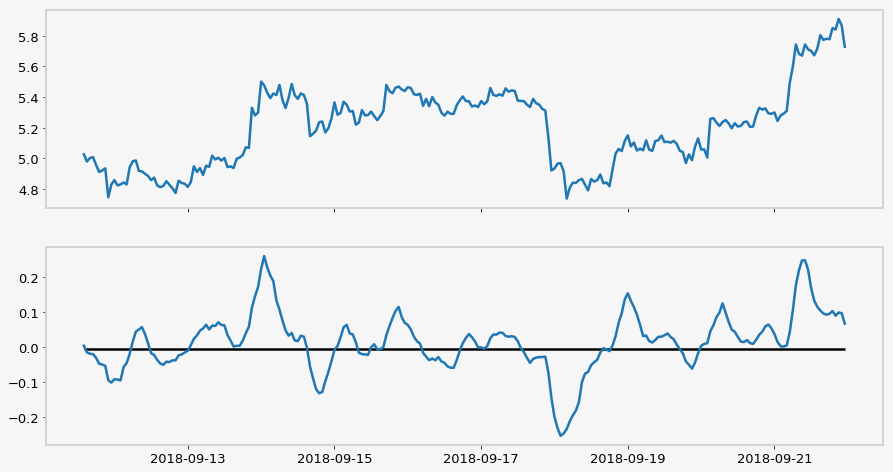

In [28]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '1H',
         'start_date':20180901000000}

Time_dict = ds.bar_reader(path,props)
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
import matplotlib.pyplot as plt

def plot_chart(close,alpha,alpha_mean=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    ax1.hlines(alpha_mean, alpha.index[-250], alpha.index[-1])
    # plt.savefig('good')
    plt.show()
def RankPct(df):
    return df.rank(axis=1, pct=True)
alpha24 = dv.add_formula('alpha24','Sma(close-Delay(close,5),5,1)',add_data=True, register_funcs={'RankPct':RankPct})
import numpy as np
a=np.nan_to_num(alpha24.values)
alpha24_mean=np.mean(a)
alpha24_plot = dv.get_ts('alpha24', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, alpha24_plot,alpha24_mean)

In [24]:
alpha24_mean

-0.005399334442087172

In [29]:

# 进场信号
short = dv.add_formula('shortAlpha24','If(Sma(close-Delay(close,5),5,1)<=-0.005399334442087172 ,-2,0)', add_data=True)
long = dv.add_formula("longAlpha24","If(Sma(close-Delay(close,5),5,1)>-0.005399334442087172 ,2,0)", add_data=True)

# 出场信号
close_long = dv.add_formula("closeLongAlpha24","If(shortAlpha24==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortAlpha24","If(longAlpha24==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha024')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdAlpha1, dv,'longAlpha24','shortAlpha24','closeLongAlpha24','closeShortAlpha24', 100, 0.05, 0.3)
tdAlpha1.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 47%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 42%
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.103  -22.869   -1.874
p-value               0.000    0.000    0.062
mean                  0.027   -0.018   -0.003
std                   0.041    0.014    0.033
info_ratio            0.666   -1.318   -0.088
skewness              2.426   -0.987    2.770
kurtosis              6.413    0.642   11.993
pct5                  0.000   -0.044   -0.041
pct25                 0.003   -0.027   -0.020
pct50                 0.009   -0.014   -0.007
pct75                 0.033   -0.007    0.003
pct95                 0.121   -0.001    0.055
occurance           149.000  302.000  451.000
win_ratio               NaN      NaN    0.330
win_mean/loss_mean      NaN      NaN    1.525


In [30]:
tdAlpha1.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               7.980  -16.139   -5.798
p-value              0.000    0.000    0.000
mean                 0.015   -0.017   -0.008
std                  0.016    0.014    0.021
info_ratio           0.954   -1.256   -0.377
skewness             0.959   -1.374    0.262
kurtosis            -0.470    1.664    1.103
pct5                 0.000   -0.047   -0.043
pct25                0.003   -0.023   -0.018
pct50                0.008   -0.014   -0.008
pct75                0.027   -0.007    0.002
pct95                0.044   -0.003    0.033
occurance           71.000  166.000  237.000
win_ratio              NaN      NaN    0.300
win_mean/loss_mean     NaN      NaN    0.849


In [31]:
tdAlpha1.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               6.493  -16.284    0.819
p-value              0.000    0.000    0.413
mean                 0.038   -0.018    0.002
std                  0.052    0.013    0.043
info_ratio           0.740   -1.401    0.056
skewness             1.637   -0.423    2.468
kurtosis             2.133   -0.860    7.216
pct5                 0.001   -0.041   -0.039
pct25                0.004   -0.028   -0.021
pct50                0.012   -0.016   -0.006
pct75                0.068   -0.007    0.005
pct95                0.130   -0.001    0.095
occurance           78.000  136.000  214.000
win_ratio              NaN      NaN    0.364
win_mean/loss_mean     NaN      NaN    2.105


因子2 蜡烛图形态Hammer和Hikkake

Initialize dataview success.
symbol               BTCUSDT:binance
trade_date                          
2018-09-04 12:00:00            100.0
2018-09-05 22:00:00            100.0
2018-09-07 12:00:00            100.0
2018-09-08 20:00:00            100.0
2018-09-16 02:00:00            100.0
2018-09-16 22:00:00            100.0
2018-09-18 04:00:00            100.0
2018-09-20 10:00:00            100.0


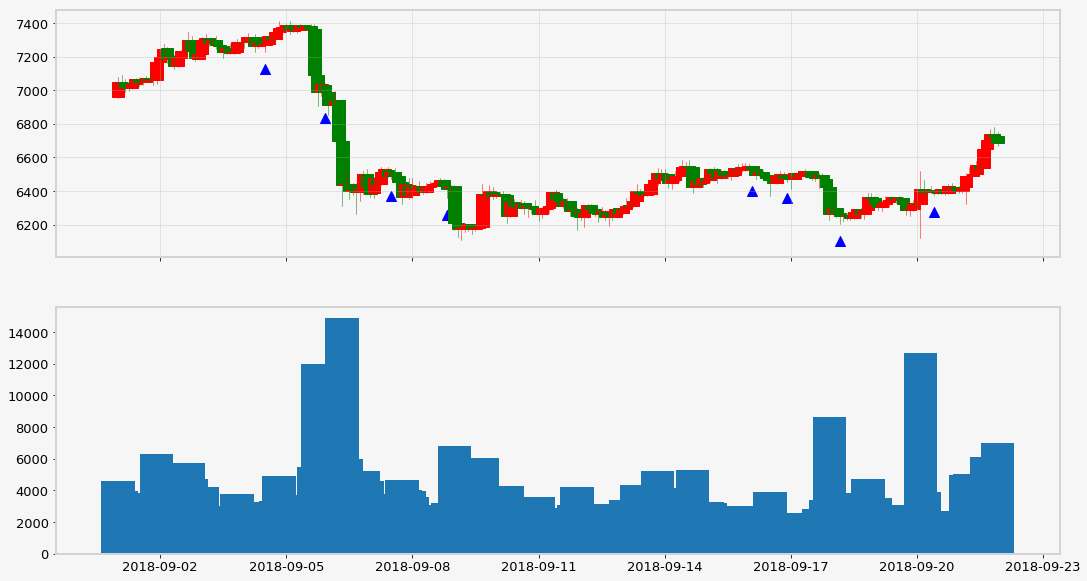

In [14]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '2H',
         'start_date':20180901000000}

Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
HAMMER = dv1H.add_formula('HAMMER', "If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HAMMERVolume = dv1H.get_ts('HAMMER', date_type='datetime')
print(HAMMERVolume[HAMMERVolume['BTCUSDT:binance']==100])

from matplotlib.pylab import date2num
import matplotlib.pyplot as plt
import matplotlib.finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values
HAMMERVolumeX = HAMMERVolume[HAMMERVolume['BTCUSDT:binance']==100].index
HAMMERVolumeY = data1H.loc[HAMMERVolumeX].low-100
draw_candle(candle, HAMMERVolumeX, HAMMERVolumeY)

symbol               BTCUSDT:binance
trade_date                          
2018-09-02 08:00:00            100.0
2018-09-04 00:00:00            100.0
2018-09-05 06:00:00            100.0
2018-09-05 22:00:00            100.0
2018-09-06 12:00:00            100.0
2018-09-09 10:00:00            100.0
2018-09-10 12:00:00            100.0
2018-09-11 22:00:00            100.0
2018-09-15 12:00:00            100.0
2018-09-16 02:00:00            100.0
2018-09-16 08:00:00            100.0
2018-09-17 20:00:00            100.0
2018-09-20 06:00:00            100.0


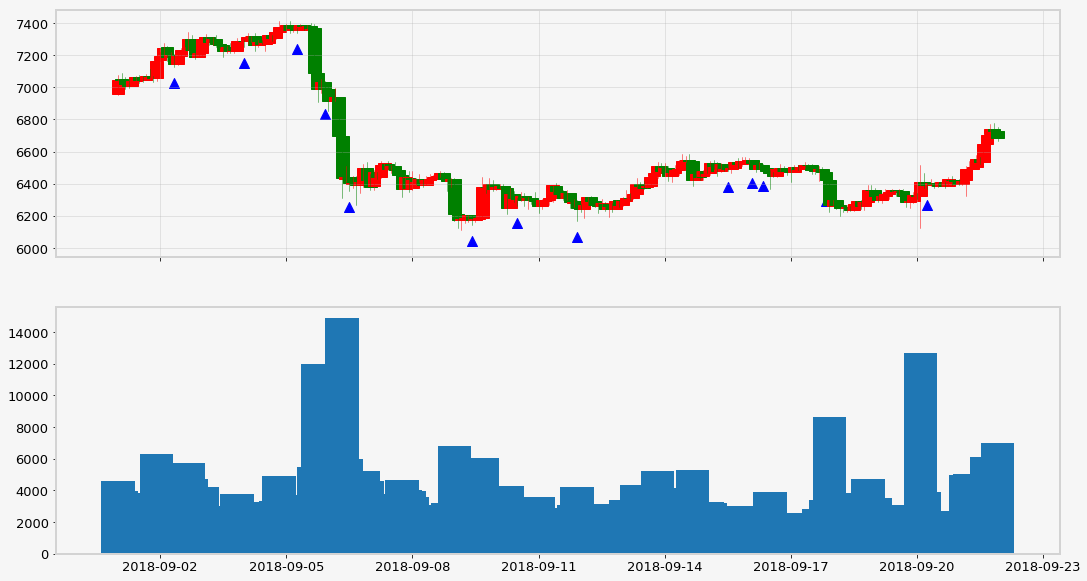

In [15]:
HIKKAKE = dv1H.add_formula('HIKKAKE', "If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HIKKAKEVolume = dv1H.get_ts('HIKKAKE', date_type='datetime')
print(HIKKAKEVolume[HIKKAKEVolume['BTCUSDT:binance']==100])
HIKKAKEVolumeX = HIKKAKEVolume[HIKKAKEVolume['BTCUSDT:binance']==100].index
HIKKAKEVolumeY = data1H.loc[HIKKAKEVolumeX].low-100
draw_candle(candle, HIKKAKEVolumeX,HIKKAKEVolumeY)

In [16]:
long = dv.add_formula('longCandle',"If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100) ,2,0)", add_data=True)
short = dv.add_formula("shortCandle","If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),-2,0)", add_data=True)

# 出场信号
close_long = dv.add_formula("closeLongCandle","If(shortCandle==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortCandle","If(longCandle==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdCandle= TimingDigger(output_folder=".", output_format='pdf',signal_name='Candle')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdCandle, dv,'longCandle','shortCandle','closeLongCandle','closeShortCandle', 100, 0.05, 0.3)
tdCandle.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              1.714  -4.271  -1.481
p-value             0.162   0.002   0.159
mean                0.020  -0.025  -0.011
std                 0.023   0.019   0.029
info_ratio          0.857  -1.351  -0.382
skewness            1.092   0.048   0.709
kurtosis           -0.404  -1.391   0.445
pct5                0.002  -0.051  -0.049
pct25               0.002  -0.040  -0.035
pct50               0.008  -0.027  -0.008
pct75               0.025  -0.008   0.002
pct95               0.056  -0.000   0.034
occurance           5.000  11.000  16.000
win_ratio             NaN     NaN   0.312
win_mean/loss_mean    NaN     NaN   0.789


In [17]:
tdCandle.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                      win   loss    all
t-stat              1.938 -9.295 -1.237
p-value             0.303  0.011  0.284
mean                0.016 -0.040 -0.018
std                 0.008  0.006  0.029
info_ratio          1.938 -6.573 -0.619
skewness            0.000 -0.159  0.427
kurtosis           -2.000 -1.500 -1.572
pct5                0.009 -0.047 -0.046
pct25               0.012 -0.044 -0.040
pct50               0.016 -0.040 -0.033
pct75               0.020 -0.036  0.008
pct95               0.024 -0.034  0.021
occurance           2.000  3.000  5.000
win_ratio             NaN    NaN  0.400
win_mean/loss_mean    NaN    NaN  0.403


In [18]:
tdCandle.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              1.094 -2.773  -0.894
p-value             0.388  0.028   0.392
mean                0.022 -0.020  -0.008
std                 0.029  0.019   0.029
info_ratio          0.773 -1.048  -0.283
skewness            0.707 -0.571   0.865
kurtosis           -1.500 -0.987   1.167
pct5                0.002 -0.049  -0.047
pct25               0.002 -0.031  -0.023
pct50               0.002 -0.016  -0.002
pct75               0.033 -0.001   0.001
pct95               0.057 -0.000   0.033
occurance           3.000  8.000  11.000
win_ratio             NaN    NaN   0.273
win_mean/loss_mean    NaN    NaN   1.141


第二部分使用了蜡烛图的两个形态同时作为对比特币投资的决策因子。首先画的图是形态Hammer出现时间与价格的走势图，从图中可以看出，大部分时间该形态都出现在一波涨势之前，但未观察到其于交易量的关系。第二个画的图为形态Hikkake出现时间与价格的走势图，从图中可以看出，当大市暴跌时，该形态都做出了预测，同时在大部分时间，市场都会在该指标出现之后有少许下跌，同时可以观察到，该指标会让比特币交易量有所提升。

因此，我们做出假设，当出现Hammer形态时我们可以做多；在出现Hikkake形态时，我们可以做空。

对因子进行绩效分析之后发现，该因子无论是盈亏比还是win_ratio都不太理想，但是单边做多的策略是三者中表现最好的一个，可以猜测Hammer形态对预测涨势有较好效果。

Initialize dataview success.
symbol               EOSUSDT:binance
trade_date                          
2018-09-03 12:00:00            100.0
2018-09-04 12:00:00            100.0
2018-09-09 10:00:00            100.0
2018-09-10 12:00:00            100.0
2018-09-17 14:00:00            100.0
2018-09-17 20:00:00            100.0
2018-09-20 10:00:00            100.0
2018-09-20 12:00:00            100.0


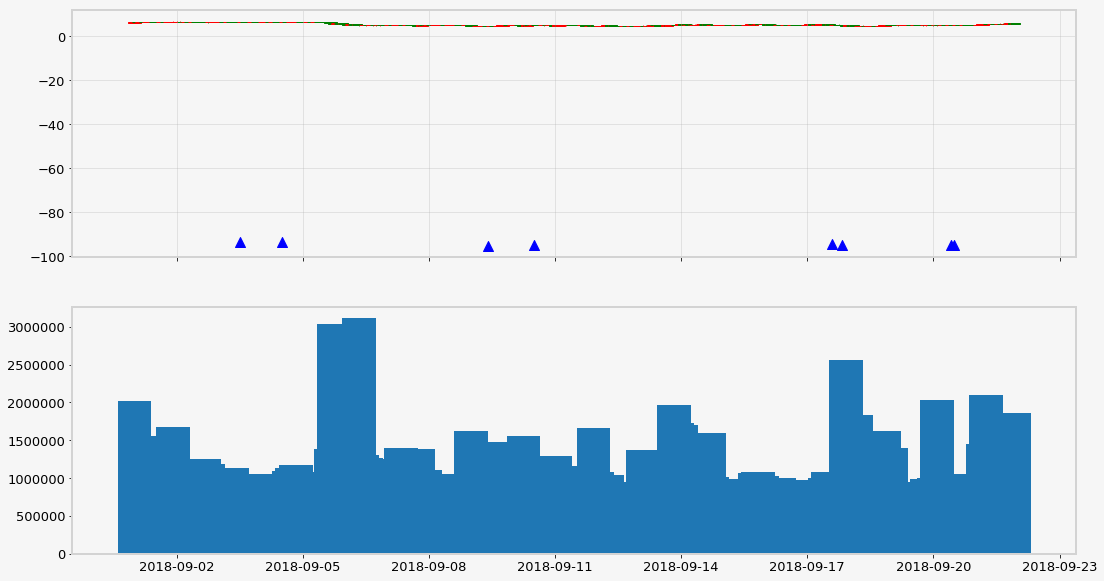

In [36]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '2H',
         'start_date':20180901000000}

Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
HAMMER = dv1H.add_formula('HAMMER', "If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HAMMERVolume = dv1H.get_ts('HAMMER', date_type='datetime')
print(HAMMERVolume[HAMMERVolume['EOSUSDT:binance']==100])

from matplotlib.pylab import date2num
import matplotlib.pyplot as plt
import matplotlib.finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values
HAMMERVolumeX = HAMMERVolume[HAMMERVolume['EOSUSDT:binance']==100].index
HAMMERVolumeY = data1H.loc[HAMMERVolumeX].low-100
draw_candle(candle, HAMMERVolumeX, HAMMERVolumeY)

symbol               EOSUSDT:binance
trade_date                          
2018-09-03 12:00:00            100.0
2018-09-04 00:00:00            100.0
2018-09-04 12:00:00            100.0
2018-09-05 00:00:00            100.0
2018-09-05 12:00:00            100.0
2018-09-05 22:00:00            100.0
2018-09-06 12:00:00            100.0
2018-09-10 12:00:00            100.0
2018-09-11 18:00:00            100.0
2018-09-11 22:00:00            100.0
2018-09-12 02:00:00            100.0
2018-09-12 14:00:00            100.0
2018-09-13 12:00:00            100.0
2018-09-15 06:00:00            100.0
2018-09-16 08:00:00            100.0
2018-09-16 20:00:00            100.0
2018-09-21 02:00:00            100.0
2018-09-21 12:00:00            100.0


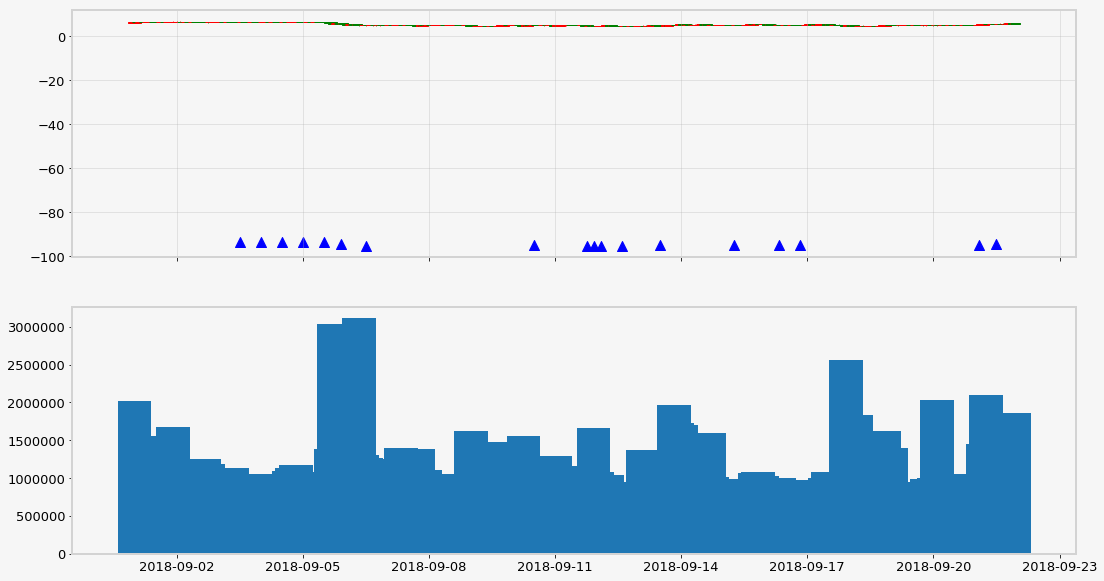

In [37]:
HIKKAKE = dv1H.add_formula('HIKKAKE', "If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HIKKAKEVolume = dv1H.get_ts('HIKKAKE', date_type='datetime')
print(HIKKAKEVolume[HIKKAKEVolume['EOSUSDT:binance']==100])
HIKKAKEVolumeX = HIKKAKEVolume[HIKKAKEVolume['EOSUSDT:binance']==100].index
HIKKAKEVolumeY = data1H.loc[HIKKAKEVolumeX].low-100
draw_candle(candle, HIKKAKEVolumeX,HIKKAKEVolumeY)

In [38]:
long = dv.add_formula('longCandle',"If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100) ,2,0)", add_data=True)
short = dv.add_formula("shortCandle","If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),-2,0)", add_data=True)

# 出场信号
close_long = dv.add_formula("closeLongCandle","If(shortCandle==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortCandle","If(longCandle==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdCandle= TimingDigger(output_folder=".", output_format='pdf',signal_name='Candle')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdCandle, dv,'longCandle','shortCandle','closeLongCandle','closeShortCandle', 100, 0.05, 0.3)
tdCandle.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               7.166  -5.085   1.602
p-value              0.000   0.000   0.117
mean                 0.037  -0.029   0.010
std                  0.026   0.023   0.041
info_ratio           1.433  -1.233   0.244
skewness             0.489  -0.495  -0.072
kurtosis            -1.375  -1.073  -0.619
pct5                 0.008  -0.061  -0.057
pct25                0.016  -0.052  -0.012
pct50                0.023  -0.021   0.013
pct75                0.068  -0.008   0.032
pct95                0.074  -0.003   0.073
occurance           26.000  18.000  44.000
win_ratio              NaN     NaN   0.591
win_mean/loss_mean     NaN     NaN   1.275


In [39]:
tdCandle.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              4.087 -2.165  -0.032
p-value             0.006  0.096   0.975
mean                0.018 -0.026  -0.000
std                 0.011  0.024   0.028
info_ratio          1.669 -1.082  -0.010
skewness            0.866 -0.404  -0.911
kurtosis            0.020 -1.795  -0.020
pct5                0.006 -0.057  -0.055
pct25               0.010 -0.053  -0.007
pct50               0.018 -0.009   0.006
pct75               0.021 -0.006   0.018
pct95               0.035 -0.004   0.030
occurance           7.000  5.000  12.000
win_ratio             NaN    NaN   0.583
win_mean/loss_mean    NaN    NaN   0.697


In [40]:
tdCandle.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               7.098  -4.500   1.745
p-value              0.000   0.001   0.091
mean                 0.044  -0.030   0.014
std                  0.026   0.023   0.044
info_ratio           1.673  -1.299   0.313
skewness             0.074  -0.553  -0.143
kurtosis            -1.685  -0.793  -0.902
pct5                 0.011  -0.066  -0.056
pct25                0.017  -0.051  -0.020
pct50                0.044  -0.022   0.015
pct75                0.069  -0.010   0.056
pct95                0.076  -0.002   0.074
occurance           19.000  13.000  32.000
win_ratio              NaN     NaN   0.594
win_mean/loss_mean     NaN     NaN   1.458
